# Design of a 2D spin Hamiltonian with topological properties

In this notebook, we show how to use QOSY to find spin-$1/2$ Hamiltonians on a 2D square lattice that commute with particular Wilson loop operators.

## The lattice

First, we use QOSY's `Lattice` class to construct a 2D square lattice: 

num_orbitals = 64


<IPython.core.display.Javascript object>


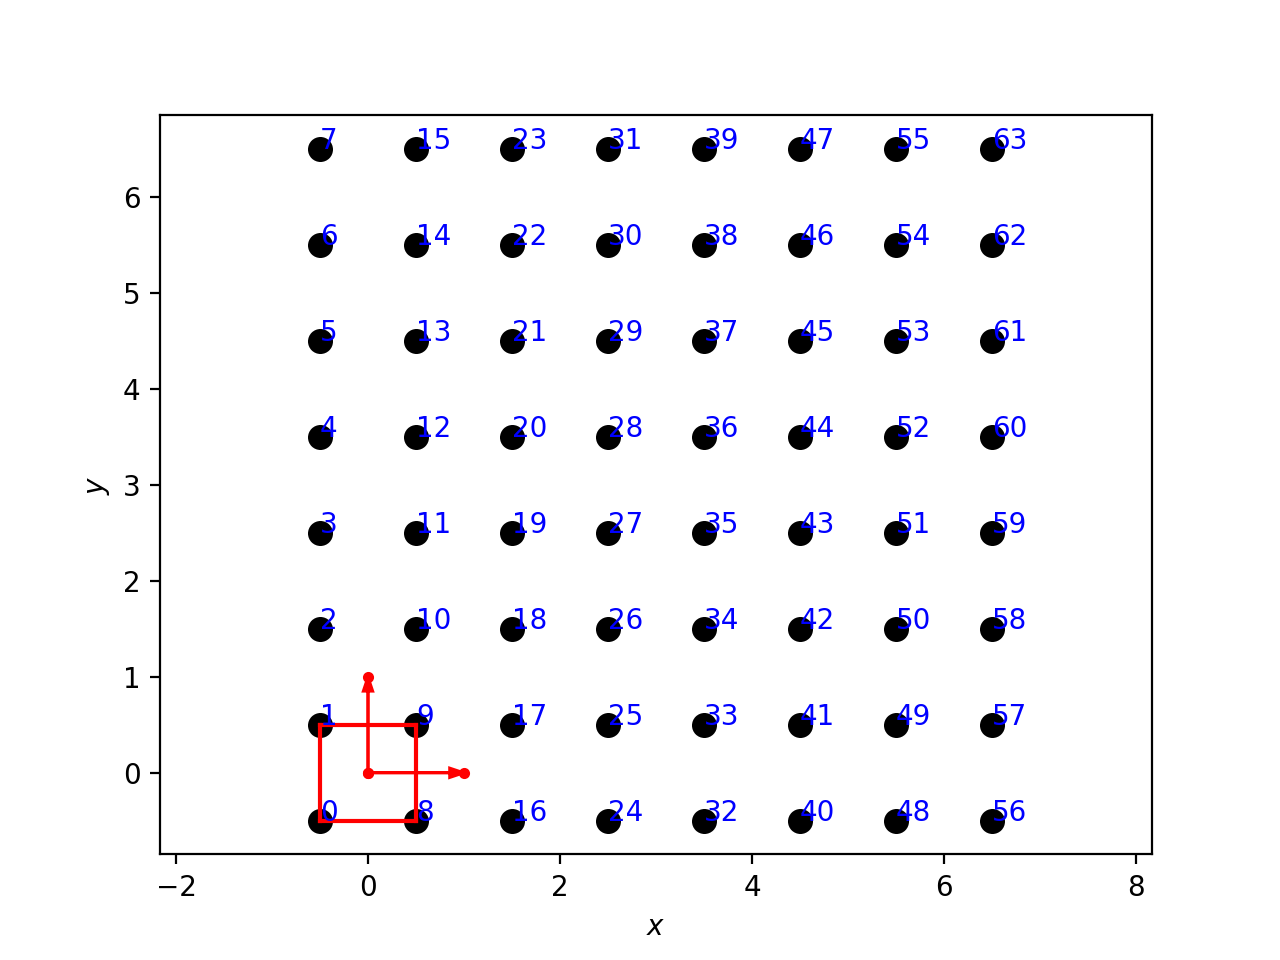

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import qosy as qy

# Lattice spacing
a  = 1.0
# Lattice vectors
a1 = a * np.array([1.0, 0.0])
a2 = a * np.array([0.0, 1.0])
lattice_vectors = [a1, a2]
    
# Positions of the three sites in a primitive unit cell.
r1    = np.zeros(2)
shift = np.array([1.0/2.0, 1.0/2.0])

positions = [r1 - shift]

# Create the star unit cell.
unit_cell = qy.UnitCell([a1, a2])
for pos in positions:
    unit_cell.add_atom(pos)

# Create a lattice with a single unit cell.
L = 8
lattice = qy.Lattice(unit_cell, (L,L), periodic_boundaries=(True,True))

# Rotation by 2pi/4
theta = 2.0*np.pi/4.0
Rmat = np.array([[np.cos(theta), -np.sin(theta)],\
                 [np.sin(theta),  np.cos(theta)]])

# Reflection about x=0
permutation2 = [lattice.index(np.array([-r[0], r[1]]), orbital_name) for (r, orbital_name,_) in lattice]
Smat = np.array([[-1,0],[0,1]],dtype=float)

# The entire symmetry group constructed from its generators
point_group_generators = [Rmat, Smat]

# Number of times to expand unit cell.
#num_expansions = 2
# Symmetrized and expanded lattice.
#lattice = qy.symmetrize_lattice(lattice, point_group_generators, num_expansions=num_expansions)

print('num_orbitals = {}'.format(len(lattice)))

# Plot the lattice for reference.
qy.plot(lattice, with_labels=True)
qy.show()

## Choose a basis of operators

Then, we build our basis of quantum operators that we would like to build Hamiltonians from. The `distance_basis` function provides a convenient way to consider a basis of $k$-local operator strings with support on orbitals up to a distance $R$ away on a lattice.

In [3]:
num_orbitals = len(lattice) 
orbitals     = np.arange(num_orbitals)

# Consider k-local operators.
k = [1,2,3,4,5]
# Consider operator strings on orbitals separated
# up to a distance of R away from one another.
R = 2.0 #np.linalg.norm(a1+a2)
basis = qy.distance_basis(lattice, k, R, 'Pauli')

print('R = {}'.format(R))
print(len(basis))
for os in basis[-10:]:
    print(os)

R = 2.0
67584
1.0 Z 45 Z 52 Y 53 Z 54 Z 61 
1.0 Z 45 Z 52 Z 53 X 54 X 61 
1.0 Z 45 Z 52 Z 53 X 54 Y 61 
1.0 Z 45 Z 52 Z 53 X 54 Z 61 
1.0 Z 45 Z 52 Z 53 Y 54 X 61 
1.0 Z 45 Z 52 Z 53 Y 54 Y 61 
1.0 Z 45 Z 52 Z 53 Y 54 Z 61 
1.0 Z 45 Z 52 Z 53 Z 54 X 61 
1.0 Z 45 Z 52 Z 53 Z 54 Y 61 
1.0 Z 45 Z 52 Z 53 Z 54 Z 61 


## Specify the desired spatial symmetries

Then, we specify our desired spatial symmetries. We use the generators of these symmetries to directly symmetrize the basis of operators. In particular, the 2D square lattice has translation and $D_4$ symmetries.

In [4]:
# Translations
T1 = qy.space_group_symmetry(lattice, np.eye(2), a1)
T2 = qy.space_group_symmetry(lattice, np.eye(2), a2)
# Rotation
theta = 2.0*np.pi/4.0
Rmatp = np.array([[np.cos(theta), -np.sin(theta)],\
                 [np.sin(theta),  np.cos(theta)]])
Rt = qy.space_group_symmetry(lattice, Rmatp, np.zeros(2))
# Reflection
St = qy.space_group_symmetry(lattice, Smat, np.zeros(2))

group_generators = [T1, T2, Rt, St]

sym_basis = qy.symmetrize_basis(basis, group_generators)

print(len(sym_basis))

234


## Specify the desired non-spatial symmetries

Then, we specify integrals of motion that we would like our Hamiltonian to commute with. We will consider Pauli string operators (or Wilson loops) so that our Hamiltonians will have topological properties.

### String operator function

This is a function we used to define our Wilson loops.

In [5]:
import numpy.linalg as nla

def string_operator(lattice, op_positions, op_names):
    op_labels = [lattice.index(pos, '') for pos in op_positions]
    
    inds_sort = np.argsort(op_labels)
    
    op_names  = [op_names[ind] for ind in inds_sort]
    op_labels = [op_labels[ind] for ind in inds_sort]
    
    os = qy.OperatorString(op_names, op_labels, 'Pauli')
    op = qy.Operator([1.0], [os])
    
    return op

### Wilson loops

Here we define $X, Y, Z$ Wilson loops that loop horizontally and vertically across the lattice

<IPython.core.display.Javascript object>


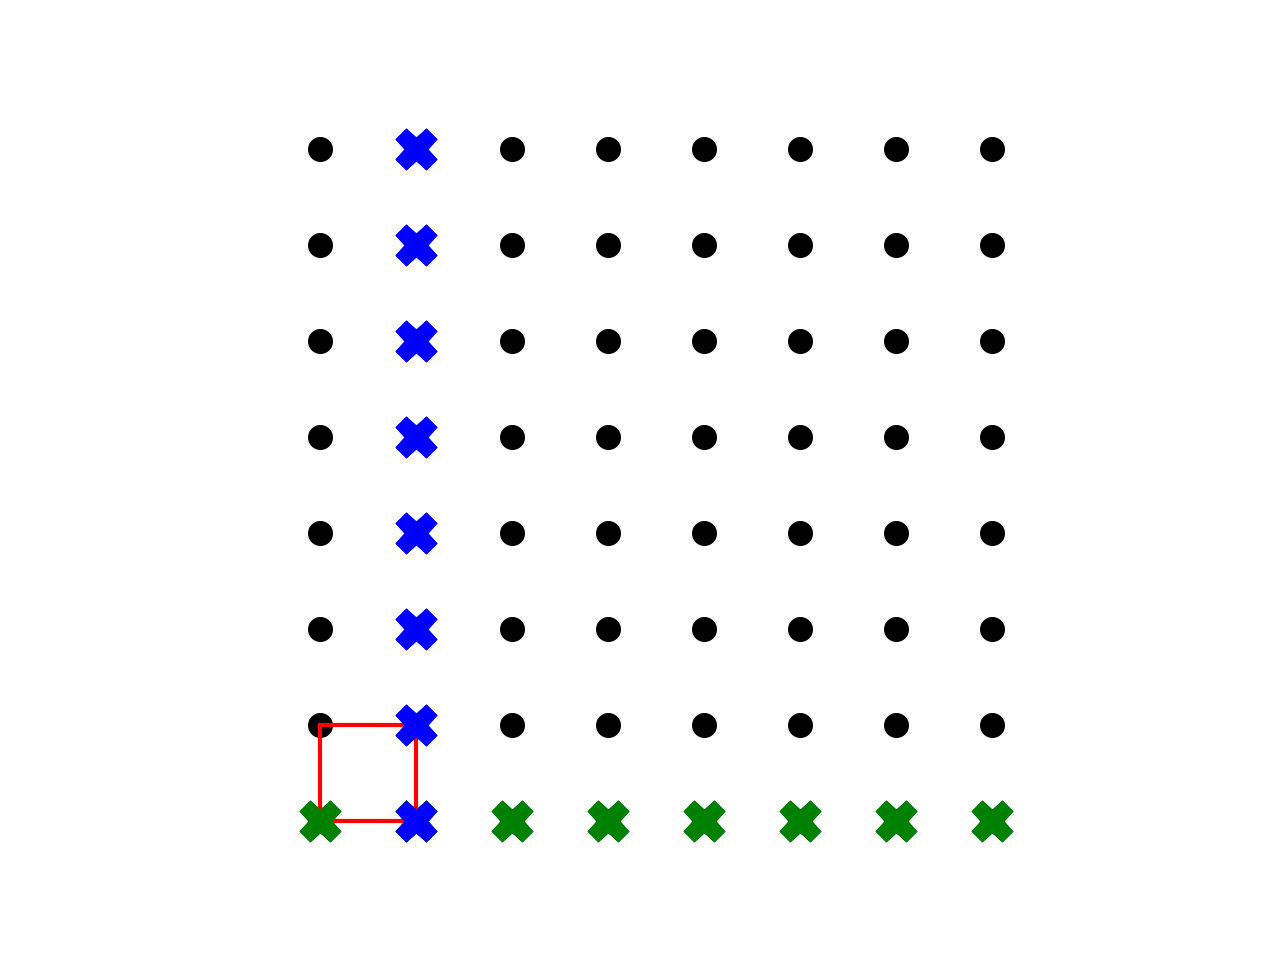

(1+0j) (1.0 X 0 X 8 X 16 X 24 X 32 X 40 X 48 X 56 )

(1+0j) (1.0 X 8 X 9 X 10 X 11 X 12 X 13 X 14 X 15 )

(1+0j) (1.0 Y 0 Y 8 Y 16 Y 24 Y 32 Y 40 Y 48 Y 56 )

(1+0j) (1.0 Y 8 Y 9 Y 10 Y 11 Y 12 Y 13 Y 14 Y 15 )

(1+0j) (1.0 Z 0 Z 8 Z 16 Z 24 Z 32 Z 40 Z 48 Z 56 )

(1+0j) (1.0 Z 8 Z 9 Z 10 Z 11 Z 12 Z 13 Z 14 Z 15 )



In [6]:
%matplotlib notebook

pos0 = lattice._orbitals[0][0]

delta = a1

theta2 = np.pi/2.0
Rmatp2 = np.array([[np.cos(theta2), -np.sin(theta2)],\
                   [np.sin(theta2),  np.cos(theta2)]])

op_positions = [np.copy(pos0)]
ind_step = 0
current_pos = pos0 + delta
while lattice.distance(current_pos, pos0) > 1e-12:
    op_positions.append(np.copy(current_pos))
    
    current_pos += delta
        
    ind_step += 1
    
lattice_positions = [lattice._orbitals[ind_orb][0] for ind_orb in range(len(lattice))]
    
qy.plot(lattice, with_labels=False, with_lattice_vectors=False)
wilson_loops = []
for op_name in ['X', 'Y', 'Z']:
    op_names = [op_name] * len(op_positions)
    op = string_operator(lattice, op_positions, op_names)
    print(op)
    wilson_loops.append(op)
    
    plot_op_positions = []
    for pos1 in op_positions:
        for pos2 in lattice_positions:
            if lattice.distance(pos1, pos2) < 1e-14:
                plot_op_positions.append(pos2)
                break
    
    xs = [pos[0] for pos in plot_op_positions]
    ys = [pos[1] for pos in plot_op_positions]
    plt.plot(xs, ys, 'gX', markersize=14)
    
    # A second rotated parity string
    op_positions2 = [np.dot(Rmatp2, pos) for pos in plot_op_positions]
    
    op = string_operator(lattice, op_positions2, op_names)
    print(op)
    wilson_loops.append(op)
    
    plot_op_positions2 = []
    for pos1 in op_positions2:
        for pos2 in lattice_positions:
            if lattice.distance(pos1, pos2) < 1e-14:
                plot_op_positions2.append(pos2)
                break
    
    xs = [pos[0] for pos in plot_op_positions2]
    ys = [pos[1] for pos in plot_op_positions2]
    plt.plot(xs, ys, 'bX', markersize=14)

plt.axis('off')
plt.show()

## Generate the symmetric operators

Finally, we generate Hamiltonians with the desired symmetries!

All we need to do is input the basis and desired symmetries into the `SymmetricOperatorGenerator` then call the `generate` method and examine the output stored in the object.

In [7]:
# Specify the symmetries.
symmetries = wilson_loops
# Define the generator using a basis of operator.
generator  = qy.SymmetricOperatorGenerator(sym_basis)
# Add the symmetries to the generator.
for symmetry in symmetries:
    generator.add_symmetry(symmetry)
    
# Generate the Hamiltonians.
generator.generate()

===== GENERATING OPERATORS =====
 STARTING WITH BASIS OF DIM 234
 COMMUTING WITH OPERATOR 1
  Generated a vector space of operators of dimension: 17
 COMMUTING WITH OPERATOR 2
  Generated a vector space of operators of dimension: 17
 COMMUTING WITH OPERATOR 3
  Generated a vector space of operators of dimension: 3
 COMMUTING WITH OPERATOR 4
  Generated a vector space of operators of dimension: 3
 COMMUTING WITH OPERATOR 5
  Generated a vector space of operators of dimension: 3
 COMMUTING WITH OPERATOR 6
  Generated a vector space of operators of dimension: 3


We found three operators that have the desired spatial symmetries and commute with the Wilson loops.

These symmetric Hamiltonians are:

In [8]:
result_ops = generator.projected_output_operators[-1]

qy.print_operators(result_ops, norm_order=np.inf, keywords=[' 0 '])

operator 1 = 
(1+0j) (1.0 Y 0 Y 1 Y 56 Y 57 )
(1+0j) (1.0 Y 0 Y 1 Y 8 Y 9 )
(1+0j) (1.0 Y 0 Y 7 Y 8 Y 15 )
(1+0j) (1.0 Y 0 Y 7 Y 56 Y 63 )

operator 2 = 
(1+0j) (1.0 X 0 X 1 X 56 X 57 )
(1+0j) (1.0 X 0 X 1 X 8 X 9 )
(1+0j) (1.0 X 0 X 7 X 8 X 15 )
(1+0j) (1.0 X 0 X 7 X 56 X 63 )

operator 3 = 
(1+0j) (1.0 Z 0 Z 1 Z 56 Z 57 )
(1+0j) (1.0 Z 0 Z 1 Z 8 Z 9 )
(1+0j) (1.0 Z 0 Z 7 Z 8 Z 15 )
(1+0j) (1.0 Z 0 Z 7 Z 56 Z 63 )



<IPython.core.display.Javascript object>


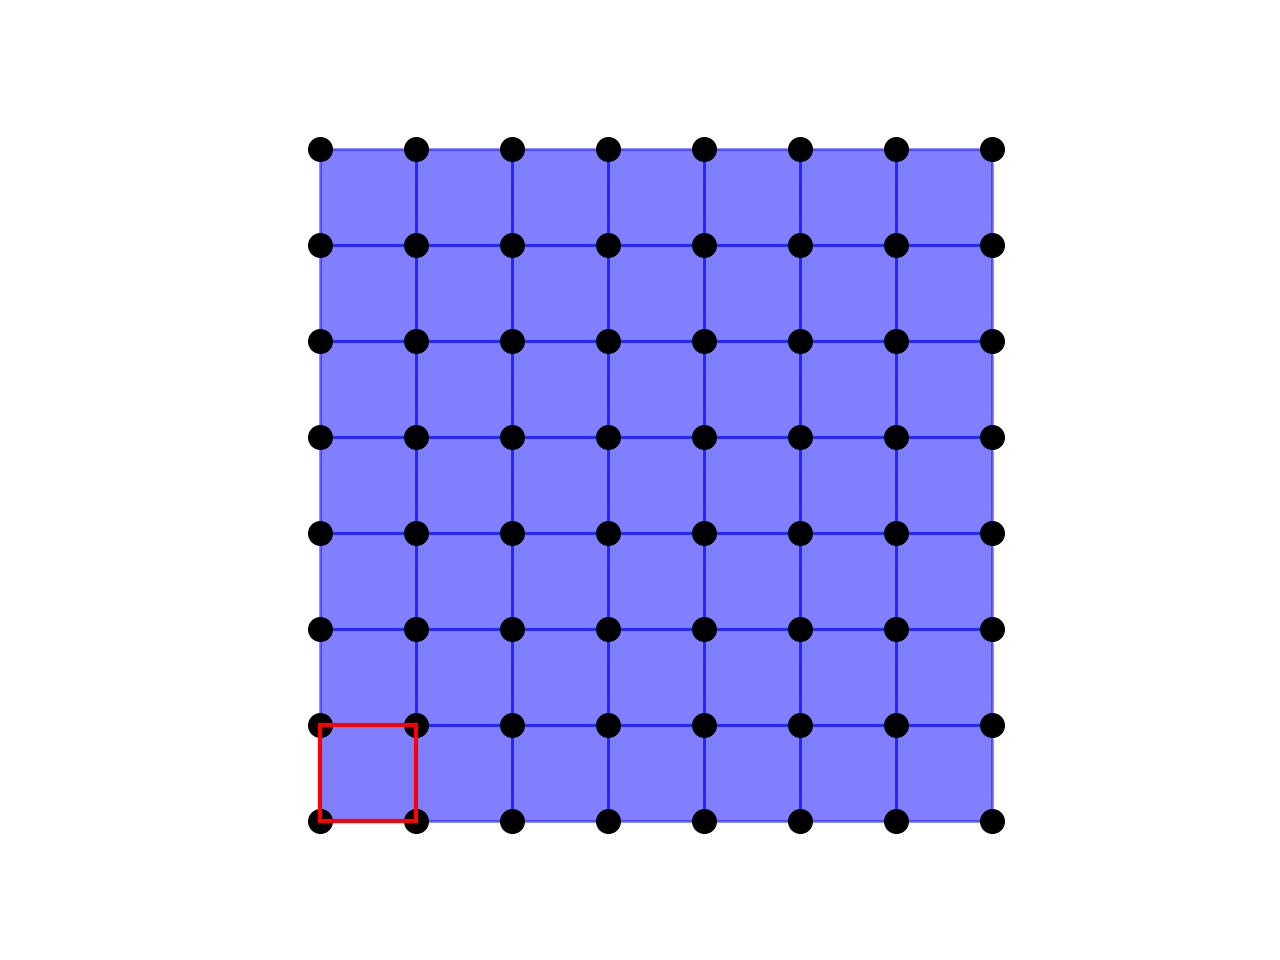

In [9]:
%matplotlib notebook

# Plot one of these operators for reference.
inds_plot = [0]
qy.plot(lattice, with_labels=False, with_lattice_vectors=False)
for ind_plot in inds_plot:
    op = result_ops[ind_plot]
    qy.plot_operator(op, lattice, distance_cutoff=R+0.1)

plt.axis('off')
qy.show()

These three Hamiltonians are equal sums of four-site $X$, $Y$, or $Z$ operators on the square plaquettes of the lattice.